In [14]:
import pandas as pd
%matplotlib inline

# Introduction

As a data scientist at Ford GoBike, a Bay Area bike share, I am trying to increase ridership.  The company would like to offer deals through the mobile app to increase ridership, but it needs to decide which plans should offer the promotions.

In this notebook, I will be answering the following question:

* What are the 5 most popular trips that could be categorized as "commuter trips"?

I will also be providing recommendations for offers based on my findings.

# Findings

## The Potential for Increasing Annual Subscribership to GoFord

Let's first answer the question as to what are the 5 most popular trips that could be categorized as "commuter trips".  The assumptions I made in determining what trips were commuter trips were the following:
* Commuter trips are made by subscribers (subscriber_type = 'Subscriber').  This group of riders would most likely take BART / Caltrain / ferry boat into San Francisco, from which they transfer to GoBike to get to work.  Local residents who work in San Francisco would most likely not be subscribers, as it makes more sense for them to own their own bicycles.
* Commuter trips have a start time before 11am.  Having a start time up to 11am accounts for the bad traffic in the Bay area.  In addition, Commuter routes in the afternoon were ignored, as they assumed to be the same stations in the opposite direction.
* Only trip counts greater than 2000 were considered based on the distribution of the data.
* The query was made over the lifetime of the dataset, and does not take into account partial years.

In the BigQuery web UI, save the results of this query in the **PopularCommuterRoutes** table:

\#standardSQL<br/>
SELECT<br/>
&nbsp;&nbsp;start_station_name,<br/>
&nbsp;&nbsp;end_station_name,<br/>
&nbsp;&nbsp;count(*) as CommuterTripCount<br/>
FROM \`bigquery-public-data.san_francisco.bikeshare_trips\`<br/>
WHERE subscriber_type = 'Subscriber' AND EXTRACT(HOUR FROM start_date) < 11<br/>
GROUP BY start_station_name, end_station_name<br/>
ORDER by CommuterTripCount DESC<br/>
HAVING CommuterTripCount > 2000<br/>

In [15]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT * FROM `eighth-orbit-193303.bike_trips_data.PopularCommuterRoutes` ORDER BY CommuterTripCount DESC LIMIT 5'  > result.csv

Waiting on bqjob_rfdf3d72235990be_00000161a5337fea_1 ... (0s) Current status: DONE   

### Five most popular trips that could be categorized as "commuter trips":

In [16]:
pop_trips=pd.read_csv('result.csv')
pop_trips

,start_station_name,end_station_name,CommuterTripCount
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4907
1,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),4304
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4246
3,Steuart at Market,2nd at Townsend,4118
4,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,3699


Note the following from the results:
The first route (Harry Bridges Plaza / 2nd at Townsend) starts at a ferry terminal.
The second, third, and fifth routes start at the Caltrain station.
The fourth route (Steuart at Market) is opposite the Harry Bridges Plaza at the ferry terminal.

So the top five routes are associated with either the ferry terminal or Caltrain stations, which supports the assumptions made for this query.

The following is a plot of the top commuter routes, which shows a comparison of the trip counts per station:

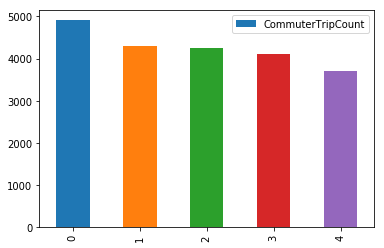

In [17]:
pop_trips.plot(kind='bar', y='CommuterTripCount')

The previous query gave the most popular routes for subscribers. But we want to know how many non-subscribers (subscriber_type = 'Customer') who also take the popular routes. By knowing this, we can target this group of riders and convert them to become subscribers.

This can be done by joining the bikeshare_trips table with the previous results, and counting how many trips for 'Subscriber' or 'Customer' match those same routes.

In the BigQuery web UI, save the results of the following query in the **PopularRoutesBreakdown** table:

#standardSQL<br/>
SELECT<br/>
&nbsp;&nbsp;Trips.start_station_name,<br/>
&nbsp;&nbsp;Trips.end_station_name,<br/>
&nbsp;&nbsp;COUNT(CASE<br/>
&nbsp;&nbsp;&nbsp;&nbsp;WHEN Trips.subscriber_type = 'Customer' THEN 1<br/>
&nbsp;&nbsp;&nbsp;&nbsp;ELSE NULL END) AS CustomerCount,<br/>
&nbsp;&nbsp;COUNT(CASE<br/>
&nbsp;&nbsp;&nbsp;&nbsp;WHEN Trips.subscriber_type = 'Subscriber' THEN 1<br/>
&nbsp;&nbsp;&nbsp;&nbsp;ELSE NULL END) AS SubscriberCount<br/>
FROM<br/>
&nbsp;&nbsp;\`bigquery-public-data.san_francisco.bikeshare_trips\` AS Trips,<br/>
&nbsp;&nbsp;\`eighth-orbit-193303.bike_trips_data.PopularCommuterRoutes\` AS PopularRoutes<br/>
WHERE<br/>
&nbsp;&nbsp;Trips.start_station_name = PopularRoutes.start_station_name<br/>
&nbsp;&nbsp;AND Trips.end_station_name = PopularRoutes.end_station_name<br/>
GROUP BY Trips.start_station_name,  Trips.end_station_name<br/>

The following query selects the percentage of riders who are customers on the popular routes from the PopularRoutesBreakdown table, ordered from greatest to smallest:

In [18]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT PopularRoutesBreakdown.start_station_name, PopularRoutesBreakdown.end_station_name, PopularRoutesBreakdown.CustomerCount * 100 / (PopularRoutesBreakdown.CustomerCount + PopularRoutesBreakdown.SubscriberCount) AS CustomerPercent FROM `eighth-orbit-193303.bike_trips_data.PopularCommuterRoutesBreakdown` AS PopularRoutesBreakdown ORDER BY CustomerPercent DESC LIMIT 5'  > result.csv

Waiting on bqjob_r6be6e6f7a7d4eb86_00000161a5338bc4_1 ... (0s) Current status: DONE   

In [19]:
pop_trips_percent_customer=pd.read_csv('result.csv')
pop_trips_percent_customer

,start_station_name,end_station_name,CustomerPercent
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,40.076503
1,Steuart at Market,Embarcadero at Sansome,16.575342
2,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),8.141593
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,8.072009
4,Steuart at Market,2nd at Townsend,4.653088


This table shows that approximately 40% of the riders on the Harry Bridges Plaza to Embarcadero at Sansome trip and 16% of the riders on the Steuart at Market to Embarcadero at Sansome trip are non-subscribing customers.

## Increasing Ridership Among Tourists and Casual Riders

If you were a tourist and wanted to do some sightseeing, how much time would you want to spend riding a bike?

The current pricing structure is the following:

* Single Ride: \\$3/30 minutes, \\$3/each additional 15 minutes
* Day Pass: \\$9.95/day for rides of 30 minutes, \\$3/each additional 15 minutes
* 3-Day Pass: \\$19.95/3 days for rides of 30 minutes, \\$3/each additional 15 minutes
* Annual Membership: \\$149 for rides of 45 minutes, \\$3/each additional 15 minutes

The current pricing structure incentivizes using bikes for a short period of time, as the cost goes up 2x after the first 30 minutes.

What are the usage patterns of tourists/casual riders?

First, let's look at the trip lengths for tourists/causal riders. The following query finds the counts of non-subscribing customers for the different usage times:

In [20]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT COUNT(CASE WHEN TIMESTAMP_DIFF(end_date, start_date, MINUTE) <= 30 THEN 1 ELSE NULL END) AS FifteenToThirtyMinutesCount, COUNT(CASE WHEN TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 31 AND 60 THEN 1 ELSE NULL END) AS ThirtyToSixtyMinutesCount, COUNT(CASE WHEN TIMESTAMP_DIFF(end_date, start_date, MINUTE) > 60 THEN 1 ELSE NULL END) AS SixtyMinutesOrMoreCount FROM \`bigquery-public-data.san_francisco.bikeshare_trips\` WHERE subscriber_type = 'Customer' AND TIMESTAMP_DIFF(end_date, start_date, MINUTE) >= 15"  > result.csv

Waiting on bqjob_r460705454f777080_00000161a5339639_1 ... (0s) Current status: DONE   

In [21]:
tourist_usage_category_counts = pd.read_csv('result.csv')
tourist_usage_category_counts.head()

,FifteenToThirtyMinutesCount,ThirtyToSixtyMinutesCount,SixtyMinutesOrMoreCount
0,44122,15740,25645


Here is a plot of the category counts for comparison:

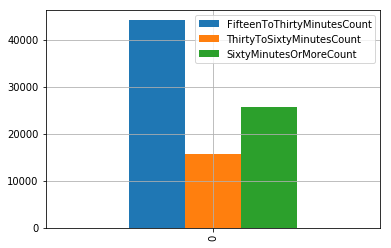

In [22]:
tourist_usage_category_counts.plot(kind='bar', grid=True)

Of the tourist / casual riders, approximately 51% ride within the 30 minute timeframe, meaning they return the bicycles on time.  18% rode for 30-60 minutes, and 30% rode for more than 60 minutes.  So almost one half the tourist / casual riders rode for more than the 30 minute base time, and were charged extra.  The data indicates that the base 30 minute rental time period is probably inappropriate for this segment of the GoFord riders.

Next, we will look at the time of day that tourists/casual riders rent GoFord bicycles.  The following is a histogram of the number of trips per hour of the day for this group:

In [23]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT HourOfDay, HourlyRideCount FROM ( SELECT EXTRACT(HOUR FROM start_date) AS HourOfDay, COUNT(*) AS HourlyRideCount FROM \`bigquery-public-data.san_francisco.bikeshare_trips\` WHERE subscriber_type = 'Customer' AND TIMESTAMP_DIFF(end_date, start_date, MINUTE) >= 15 GROUP BY EXTRACT(HOUR FROM start_date) ) ORDER BY HourOfDay"  > result.csv

Waiting on bqjob_r5e53911f2121a5f2_00000161a533a1c2_1 ... (0s) Current status: DONE   

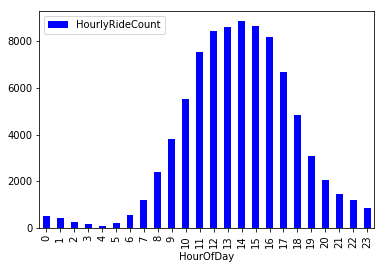

In [24]:
tourist_hourly_rental_counts = pd.read_csv('result.csv')
tourist_hourly_rental_counts.plot(kind='bar', x='HourOfDay', y='HourlyRideCount', color='b')

As compared with commuters who use the rental bike service during the morning and evening commute to and from work, the rentals by tourists/casual riders is normally distributed and peaks around 2pm.

## Improving Ridership throughout the Year

Instead of focusing on just one segment of the ridership such as commuters, it might be helpful to look at the trend in ridership throughout the year.  The following query gets the number of trips per week for the years that had complete data (2014-2015):

In [25]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT WeekOfYear, WeeklyTripCount FROM (SELECT EXTRACT(WEEK FROM start_date) AS WeekOfYear, COUNT(*) AS WeeklyTripCount FROM \`bigquery-public-data.san_francisco.bikeshare_trips\` WHERE EXTRACT(YEAR FROM start_date) IN (2014, 2015) GROUP BY EXTRACT(WEEK FROM start_date) ) AS TripCountsPerWeek ORDER BY WeekOfYear ASC"  > result.csv

Waiting on bqjob_rf3e0c50356dfce7_00000161a533ad2b_1 ... (0s) Current status: DONE   

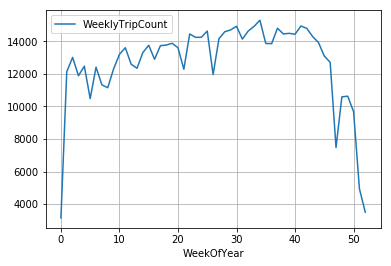

In [26]:
weekly_rental_counts = pd.read_csv('result.csv')
weekly_rental_counts.plot(kind='line', x='WeekOfYear', y='WeeklyTripCount', grid=True)

Note that the ridership trend (weekly trip count) steadily increases until it peaks between week 34 and 41, and sharply drops until the end of the year.  This trend is positively correlated with the average temperature and negatively correlated with the average rainfall in San Francisco:

![Average Temperature](SFAvgTemp.png)![Average Rainfall](SFAvgRainfall.png)

# Recommendations

Since the database does not track usage of individual riders throughout the day, and the database does not distinguish between one time, 1 day and 3 day passes, it is difficult to get insight into the usage patterns of non-subscribers. Therefore the focus of my analysis was on two segments of riders: subscribers (assumed to be generally commuters) and non-subscribers (assumed to be tourist/casual riders).

Based on the above findings, here are my recommendations.

1. **Have an online ad campaign to convert many of the non-subscribing commuters on the most popular commuter routes.**
Among the most popular commuter routes, the following routes have the highest percentages of non-subscribers:
        Harry Bridges Plaza to Embarcadero at Sansome (40%)
        Steuart at Market to Embarcadero at Sansome	(16.6%)
 Non-subscribing commuters on these routes (especially the Harry Bridges Plaza to Embarcadero at Sansome trip) would be ideal to promote an annual membership to through an online ad campaign.
2. **Investigate a different pricing model for tourist/casual riders.**
The usage patterns of tourist / casual riders shows that nearly 48% used GoFord bicycles for more than the 30 minute base time, and most rentals occurred mid-day (around 2pm). Due to the limitations with the available data, it is impossible to know if some of these riders have 1 or 3 day passes, and also when they return their bicycles, if they continue riding.  But the data does show that 30 minute base time does not work for nearly half of these riders.  It could be that many *potential* tourist / casual riders are turned off by the 30 minute price increase.  A recommendation would be to investigate whether a different pricing for mid-day rentals to stay constant at \$3 for the next 30 minutes would increase ridership.  It would also need to be determined if this would affect the number of customers who rent for 1 day.
3. **Off season price reduction for non-subscriber rentals.**
Ridership is moderately low in January, and sharply declines in November and December. An online ad campaign and price reduction could be targeted at single ride, 1 day, and 3 day rentals during the months of January, November, and December to increase ridership.